In [3]:
import pandas as pd

# Load the CMAPSS dataset
file_path = "train_FD001.txt"
column_names = ["unit_number", "time_in_cycles"] + [f"op_setting_{i}" for i in range(1, 4)] + [f"sensor_measurement_{i}" for i in range(1, 22)]
df = pd.read_csv(file_path, sep="\s+", header=None, names=column_names)

# Calculate Remaining Useful Life (RUL)
df["max_cycle"] = df.groupby("unit_number")["time_in_cycles"].transform("max")
df["RUL"] = df["max_cycle"] - df["time_in_cycles"]

# Select relevant columns for modeling
df_model = df[["unit_number", "time_in_cycles", "RUL", "sensor_measurement_2", "sensor_measurement_3"]]

# Display sample
df_model.head()


,unit_number,time_in_cycles,RUL,sensor_measurement_2,sensor_measurement_3
0,1,1,191,641.82,1589.70
1,1,2,190,642.15,1591.82
2,1,3,189,642.35,1587.99
3,1,4,188,642.35,1582.79
4,1,5,187,642.37,1582.85


In [2]:
! pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=1e7501664cea6a48f64f19d46a34f0e1552c15c022407631254e417ab0c80664
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from lifelines import WeibullAFTFitter
import matplotlib.pyplot as plt
from lifelines.utils import ConvergenceError

# Load dataset
column_names = ["unit_number", "time_in_cycles"] + \
               [f"op_setting_{i}" for i in range(1, 4)] + \
               [f"sensor_measurement_{i}" for i in range(1, 22)]

df = pd.read_csv("train_FD001.txt", sep="\s+", header=None, names=column_names)

# Calculate RUL
df["max_cycle"] = df.groupby("unit_number")["time_in_cycles"].transform("max")
df["RUL"] = df["max_cycle"] - df["time_in_cycles"]

# Subset for modeling
df_model = df[["unit_number", "time_in_cycles", "RUL", "sensor_measurement_2", "sensor_measurement_3"]]

# Exponential regression using Poisson with log link
X = df_model[["sensor_measurement_2", "sensor_measurement_3"]]
X = sm.add_constant(X)
y = df_model["RUL"]
glm_model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.log()))
glm_results = glm_model.fit()

# Weibull AFT model using lifelines
aft_df = df_model[["RUL", "sensor_measurement_2", "sensor_measurement_3"]].copy()
aft_df["event_observed"] = 1

aft = WeibullAFTFitter()
aft.fit(aft_df, duration_col="RUL", event_col="event_observed")

# Plot Exponential Regression predictions
df_model["predicted_rul_exp"] = glm_results.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(df_model["RUL"], df_model["predicted_rul_exp"], alpha=0.3, color="red")
plt.plot([0, df_model["RUL"].max()], [0, df_model["RUL"].max()], "k--")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL (Exponential Regression)")
plt.title("Exponential Regression: Actual vs Predicted RUL")
plt.tight_layout()
plt.savefig("exp_regression_rul.png")
plt.show()

# Output results
print("Exponential Regression Summary:")
print(glm_results.summary())
print("\nWeibull AFT Model Summary:")
print(aft.summary)


# Fix the ValueError by adding a small positive value (epsilon) to any zero RUL values
aft_df["RUL"] = aft_df["RUL"].apply(lambda x: x if x > 0 else 1e-3)

# Retry fitting the Weibull AFT model
from lifelines import WeibullAFTFitter
from lifelines.utils import ConvergenceError

aft = WeibullAFTFitter()
try:
    aft.fit(aft_df, duration_col="RUL", event_col="event_observed")
    aft_summary = aft.summary
except ConvergenceError as e:
    aft_summary = str(e)

aft_summary


import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from lifelines import WeibullAFTFitter

# Load data
column_names = ["unit_number", "time_in_cycles"] + \
    [f"op_setting_{i}" for i in range(1, 4)] + \
    [f"sensor_measurement_{i}" for i in range(1, 22)]

df = pd.read_csv("train_FD001.txt", sep="\s+", header=None, names=column_names)

# Calculate Remaining Useful Life (RUL)
df["max_cycle"] = df.groupby("unit_number")["time_in_cycles"].transform("max")
df["RUL"] = df["max_cycle"] - df["time_in_cycles"]

# Select features for modeling
df_model = df[["unit_number", "time_in_cycles", "RUL", "sensor_measurement_2", "sensor_measurement_3"]]

# Exponential regression via Poisson with log link
X = df_model[["sensor_measurement_2", "sensor_measurement_3"]]
X = sm.add_constant(X)
y = df_model["RUL"]

glm_model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.Log()))
glm_results = glm_model.fit()

# Prepare for Weibull AFT model
aft_df = df_model[["RUL", "sensor_measurement_2", "sensor_measurement_3"]].copy()
aft_df["event_observed"] = 1
aft_df["RUL"] = aft_df["RUL"].apply(lambda x: x if x > 0 else 1e-3)

aft = WeibullAFTFitter()
aft.fit(aft_df, duration_col="RUL", event_col="event_observed")

# Plot: Exponential Regression Predictions
df_model["predicted_rul_exp"] = glm_results.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(df_model["RUL"], df_model["predicted_rul_exp"], alpha=0.3, color="red")
plt.plot([0, df_model["RUL"].max()], [0, df_model["RUL"].max()], "k--")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL (Exponential)")
plt.title("Exponential Regression: Actual vs Predicted R ​:contentReference[oaicite:0]{index=0}​")


df_model["predicted_rul_weibull"] = aft.predict_median(aft_df)

plt.figure(figsize=(10, 6))
plt.scatter(df_model["RUL"], df_model["predicted_rul_weibull"], alpha=0.3, color="blue")
plt.plot([0, df_model["RUL"].max()], [0, df_model["RUL"].max()], "k--")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL (Weibull AFT)")
plt.title("Weibull Regression: Actual vs Predicted RUL")
plt.tight_layout()
plt.savefig("weibull_regression_rul.png")
plt.show()


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=100, max_depth=10)
rf.fit(X[["sensor_measurement_2", "sensor_measurement_3"]], y)
df_model["predicted_rul_rf"] = rf.predict(X[["sensor_measurement_2", "sensor_measurement_3"]])

mse = mean_squared_error(df_model["RUL"], df_model["predicted_rul_rf"])
print(f"RF MSE: {mse:.2f}")

from sklearn.metrics import mean_absolute_error

rmse_exp = mean_squared_error(df_model["RUL"], df_model["predicted_rul_exp"])
print(f"Exponential RMSE: {rmse_exp:.2f}")

# Generate Weibull predictions
df_model["predicted_rul_weibull"] = aft.predict_median(aft_df)

# Compute RMSE for Weibull model
from sklearn.metrics import mean_squared_error

rmse_weibull = mean_squared_error(df_model["RUL"], df_model["predicted_rul_weibull"])

# Plot Actual vs Predicted for Weibull AFT
plt.figure(figsize=(10, 6))
plt.scatter(df_model["RUL"], df_model["predicted_rul_weibull"], alpha=0.3, color="blue")
plt.plot([0, df_model["RUL"].max()], [0, df_model["RUL"].max()], "k--")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL (Weibull AFT)")
plt.title("Weibull Regression: Actual vs Predicted RUL")
plt.tight_layout()
plt.savefig("weibull_regression_rul.png")
plt.show()

rmse_weibull


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select only the sensor measurements
sensor_cols = [col for col in df.columns if "sensor_measurement" in col]
sensor_data = df[sensor_cols]

# Standardize the sensor data
scaler = StandardScaler()
sensor_scaled = scaler.fit_transform(sensor_data)

# Apply PCA and retain 3 principal components
pca = PCA(n_components=3)
pca_components = pca.fit_transform(sensor_scaled)

# Add PCA components to the model dataframe
pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2", "PC3"])
df_model_pca = pd.concat([df_model.reset_index(drop=True), pca_df], axis=1)

# Prepare AFT model data with PCA components
aft_pca_df = df_model_pca[["RUL", "PC1", "PC2", "PC3"]].copy()
aft_pca_df["event_observed"] = 1
aft_pca_df["RUL"] = aft_pca_df["RUL"].apply(lambda x: x if x > 0 else 1e-3)

# Fit Weibull AFT model using PCA components
aft_pca = WeibullAFTFitter()
aft_pca.fit(aft_pca_df, duration_col="RUL", event_col="event_observed")

# Predict and plot
df_model_pca["predicted_rul_weibull_pca"] = aft_pca.predict_median(aft_pca_df)
rmse_weibull_pca = mean_squared_error(df_model_pca["RUL"], df_model_pca["predicted_rul_weibull_pca"])

plt.figure(figsize=(10, 6))
plt.scatter(df_model_pca["RUL"], df_model_pca["predicted_rul_weibull_pca"], alpha=0.3, color="purple")
plt.plot([0, df_model_pca["RUL"].max()], [0, df_model_pca["RUL"].max()], "k--")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL (Weibull AFT with PCA)")
plt.title("Weibull Regression with PCA: Actual vs Predicted RUL")
plt.tight_layout()
plt.savefig("weibull_pca_rul.png")
plt.show()

rmse_weibull_pca


import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from lifelines import WeibullAFTFitter

# Log-transform the sensor values
epsilon = 1e-6
sensor_log = np.log(df[sensor_cols] + epsilon)

# Standardize
sensor_scaled_log = StandardScaler().fit_transform(sensor_log)

# PCA
pca_log = PCA(n_components=3)
pca_log_components = pca_log.fit_transform(sensor_scaled_log)

# Combine with model data
pca_log_df = pd.DataFrame(pca_log_components, columns=["PC1_log", "PC2_log", "PC3_log"])
df_model_logpca = pd.concat([df_model.reset_index(drop=True), pca_log_df], axis=1)

# Prepare AFT model input
aft_log_df = df_model_logpca[["RUL", "PC1_log", "PC2_log", "PC3_log"]].copy()
aft_log_df["event_observed"] = 1
aft_log_df["RUL"] = aft_log_df["RUL"].apply(lambda x: x if x > 0 else 1e-3)

# Fit Weibull AFT
aft_log = WeibullAFTFitter()
aft_log.fit(aft_log_df, duration_col="RUL", event_col="event_observed")

# Predict and score
df_model_logpca["predicted_rul_weibull_logpca"] = aft_log.predict_median(aft_log_df)
from sklearn.metrics import mean_squared_error
rmse_logpca = mean_squared_error(df_model_logpca["RUL"], df_model_logpca["predicted_rul_weibull_logpca"])

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(df_model_logpca["RUL"], df_model_logpca["predicted_rul_weibull_logpca"], alpha=0.3, color="darkgreen")
plt.plot([0, df_model_logpca["RUL"].max()], [0, df_model_logpca["RUL"].max()], "k--")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL (Log PCA Weibull)")
plt.title("Weibull AFT with Log-Transformed PCA Features")
plt.tight_layout()
plt.savefig("weibull_logpca_rul.png")
plt.show()

print(f"Weibull Log-PCA RMSE: {rmse_logpca:.2f}")

import numpy as np

# Copy of full data
df_censored = df.copy()

# Simulate censoring: randomly select 20% of units to censor
np.random.seed(42)
units_to_censor = np.random.choice(df["unit_number"].unique(), size=int(0.2 * df["unit_number"].nunique()), replace=False)

# Truncate these units at 70% of their lifetime
for unit in units_to_censor:
    max_cycle = df_censored[df_censored["unit_number"] == unit]["time_in_cycles"].max()
    cutoff = int(max_cycle * 0.7)
    df_censored = df_censored[~((df_censored["unit_number"] == unit) & (df_censored["time_in_cycles"] > cutoff))]
# Add RUL again
df_censored["max_cycle"] = df_censored.groupby("unit_number")["time_in_cycles"].transform("max")
df_censored["RUL"] = df_censored["max_cycle"] - df_censored["time_in_cycles"]

# Create event_observed: 1 = failure, 0 = censored
df_censored["event_observed"] = 1
df_censored.loc[df_censored["unit_number"].isin(units_to_censor), "event_observed"] = 0
from lifelines import WeibullAFTFitter

# Example using PCA features or raw features
aft_df = df_censored[["RUL", "sensor_measurement_2", "sensor_measurement_3", "event_observed"]].copy()
aft_df["RUL"] = aft_df["RUL"].apply(lambda x: x if x > 0 else 1e-3)

aft = WeibullAFTFitter()
aft.fit(aft_df, duration_col="RUL", event_col="event_observed")
aft.print_summary()


# Prepare data for CoxPH and DeepSurv models
from lifelines import CoxPHFitter

# Columns already prepared: sensor_measurement_2, sensor_measurement_3, RUL, event_observed
cox_df = df_censored[["RUL", "event_observed", "sensor_measurement_2", "sensor_measurement_3"]].copy()
cox_df["RUL"] = cox_df["RUL"].apply(lambda x: x if x > 0 else 1e-3)

# Fit Cox Proportional Hazards model
cox_model = CoxPHFitter()
cox_model.fit(cox_df, duration_col="RUL", event_col="event_observed")

# Evaluate Concordance Index
cox_concordance = cox_model.concordance_index_

cox_concordance


from lifelines import CoxPHFitter

cox_df = df_censored[["RUL", "event_observed", "sensor_measurement_2", "sensor_measurement_3"]].copy()
cox_df["RUL"] = cox_df["RUL"].apply(lambda x: x if x > 0 else 1e-3)

cox_model = CoxPHFitter()
cox_model.fit(cox_df, duration_col="RUL", event_col="event_observed")

print("CoxPH Concordance:", cox_model.concordance_index_)
print(cox_model.summary)





/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


ValueError: This model does not allow for non-positive durations. Suggestion: add a small positive value to zero elements.

In [15]:
import numpy as np
import pandas as pd

# Features
X = df_censored[["sensor_measurement_2", "sensor_measurement_3"]].astype(np.float32).values

# Durations and event indicator
T = df_censored["RUL"].clip(lower=1e-3).astype(np.float32).values
E = df_censored["event_observed"].astype(np.int32).values

train_data = {'x': X, 't': T, 'e': E}

from deepsurv import DeepSurv

# Minimal hyperparameters
params = {
    'n_in': X.shape[1],
    'learning_rate': 1e-4,
    'hidden_layers_sizes': [32, 16],
    'dropout': 0.1,
    'activation': 'relu',
    'L2_reg': 1e-4,
    'batch_norm': True
}

net = DeepSurv(**params)
log = net.train(train_data, train_data, n_epochs=500)



SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (deep_surv.py, line 326)

ModuleNotFoundError: No module named 'deepsurv'

In [1]:
from pycox.models import DeepSurv
import torchtuples as tt
from pycox.evaluation import EvalSurv
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare data
features = ["sensor_measurement_2", "sensor_measurement_3"]
X = df_censored[features].astype(np.float32).values
T = df_censored["RUL"].clip(lower=1e-3).astype(np.float32).values
E = df_censored["event_observed"].astype(np.int32).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Build and train network
net = tt.practical.MLPVanilla(X.shape[1], [32, 16], 1, activation='ReLU')
model = DeepSurv(net, tt.optim.Adam)

model.fit(X_scaled, (T, E), batch_size=256, epochs=100)

# Predict and evaluate
surv = model.predict_surv_df(X_scaled)
ev = EvalSurv(surv, T, E, censor_surv='km')
print("DeepSurv (pycox) Concordance:", ev.concordance_td('antolini'))


ImportError: cannot import name 'DeepSurv' from 'pycox.models' (/usr/local/lib/python3.11/dist-packages/pycox/models/__init__.py)

In [19]:
!pip install --upgrade --force-reinstall pycox torchtuples


  Using cached pycox-0.3.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached torchtuples-0.2.2-py3-none-any.whl.metadata (3.8 kB)
  Using cached feather_format-0.4.1-py3-none-any.whl
  Using cached py7zr-0.22.0-py3-none-any.whl.metadata (16 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 8.8 MB/s eta 0:00:00
  Using cached texttable-1.7.0-py2.py3-none-any.whl.metadata (9.8 kB)
  Using cached pyzstd-0.17.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached pyppmd-1.1.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached pybcj-1.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.7 kB)
  Using cached multivolumefile-0.2.3-py3-none-any.whl.metadata (6.3 kB)
  Using cached inflate64-1.0.1-cp311-cp311-manylinux_2_17

In [2]:
# Refactored CMAPSS RUL modeling code

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from lifelines import WeibullAFTFitter, CoxPHFitter
from lifelines.utils import ConvergenceError


def load_and_prepare_data(filepath: str) -> pd.DataFrame:
    """Loads CMAPSS dataset and computes RUL.

    Args:
        filepath: Path to the CMAPSS FD001 dataset file.

    Returns:
        DataFrame with RUL computed per unit.
    """
    column_names = ["unit_number", "time_in_cycles"] + \
                   [f"op_setting_{i}" for i in range(1, 4)] + \
                   [f"sensor_measurement_{i}" for i in range(1, 22)]

    df = pd.read_csv(filepath, sep="\s+", header=None, names=column_names)
    df["max_cycle"] = df.groupby("unit_number")["time_in_cycles"].transform("max")
    df["RUL"] = df["max_cycle"] - df["time_in_cycles"]
    return df


def fit_exponential_model(df_model: pd.DataFrame):
    """Fits exponential regression model using Poisson with log link.

    Args:
        df_model: DataFrame with selected features.

    Returns:
        Fitted GLM results object.
    """
    X = sm.add_constant(df_model[["sensor_measurement_2", "sensor_measurement_3"]])
    y = df_model["RUL"]
    model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.Log()))
    return model.fit()


def fit_weibull_model(df_model: pd.DataFrame):
    """Fits a Weibull AFT model using lifelines.

    Args:
        df_model: DataFrame with RUL and sensor data.

    Returns:
        Fitted WeibullAFTFitter model.
    """
    aft_df = df_model[["RUL", "sensor_measurement_2", "sensor_measurement_3"]].copy()
    aft_df["event_observed"] = 1
    aft_df["RUL"] = aft_df["RUL"].clip(lower=1e-3)
    aft = WeibullAFTFitter()
    aft.fit(aft_df, duration_col="RUL", event_col="event_observed")
    return aft


def simulate_censoring(df: pd.DataFrame, censor_rate: float = 0.2) -> pd.DataFrame:
    """Simulates right censoring in CMAPSS data.

    Args:
        df: Full DataFrame with RUL.
        censor_rate: Proportion of units to censor.

    Returns:
        Censored DataFrame.
    """
    df_censored = df.copy()
    np.random.seed(42)
    units = df["unit_number"].unique()
    censored_units = np.random.choice(units, int(censor_rate * len(units)), replace=False)

    for unit in censored_units:
        max_cycle = df_censored[df_censored["unit_number"] == unit]["time_in_cycles"].max()
        cutoff = int(max_cycle * 0.7)
        df_censored = df_censored[~((df_censored["unit_number"] == unit) & (df_censored["time_in_cycles"] > cutoff))]

    df_censored["max_cycle"] = df_censored.groupby("unit_number")["time_in_cycles"].transform("max")
    df_censored["RUL"] = df_censored["max_cycle"] - df_censored["time_in_cycles"]
    df_censored["event_observed"] = 1
    df_censored.loc[df_censored["unit_number"].isin(censored_units), "event_observed"] = 0
    return df_censored


def fit_random_forest(df_model: pd.DataFrame) -> RandomForestRegressor:
    """Fits a Random Forest regressor.

    Args:
        df_model: DataFrame with sensor features and RUL.

    Returns:
        Trained RandomForestRegressor.
    """
    X = df_model[["sensor_measurement_2", "sensor_measurement_3"]]
    y = df_model["RUL"]
    rf = RandomForestRegressor(n_estimators=100, max_depth=10)
    rf.fit(X, y)
    return rf


def apply_pca_and_fit_weibull(df: pd.DataFrame, log_transform: bool = False) -> tuple[WeibullAFTFitter, float]:
    """Applies PCA (optionally with log transform) and fits a Weibull model.

    Args:
        df: DataFrame with RUL and sensors.
        log_transform: Whether to log-transform sensor values.

    Returns:
        Tuple of fitted Weibull model and RMSE.
    """
    sensor_cols = [col for col in df.columns if "sensor_measurement" in col]
    sensor_data = df[sensor_cols]
    if log_transform:
        sensor_data = np.log(sensor_data + 1e-6)

    sensor_scaled = StandardScaler().fit_transform(sensor_data)
    pca = PCA(n_components=3)
    pca_components = pca.fit_transform(sensor_scaled)
    pca_df = pd.DataFrame(pca_components, columns=["PC1", "PC2", "PC3"])
    df_model = pd.concat([df.reset_index(drop=True), pca_df], axis=1)

    aft_df = df_model[["RUL", "PC1", "PC2", "PC3"]].copy()
    aft_df["event_observed"] = 1
    aft_df["RUL"] = aft_df["RUL"].clip(lower=1e-3)

    aft = WeibullAFTFitter()
    aft.fit(aft_df, duration_col="RUL", event_col="event_observed")
    preds = aft.predict_median(aft_df)
    rmse = mean_squared_error(df_model["RUL"], preds)
    return aft, rmse


def fit_cox_model(df: pd.DataFrame) -> CoxPHFitter:
    """Fits a Cox Proportional Hazards model.

    Args:
        df: DataFrame with RUL, event, and sensor data.

    Returns:
        Fitted CoxPHFitter model.
    """
    df = df[["RUL", "event_observed", "sensor_measurement_2", "sensor_measurement_3"]].copy()
    df["RUL"] = df["RUL"].clip(lower=1e-3)
    model = CoxPHFitter()
    model.fit(df, duration_col="RUL", event_col="event_observed")
    return model


/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


Exponential RMSE: 2934.51
Weibull RMSE (nonlinear): 2877.54
Cox Concordance (nonlinear): 0.73


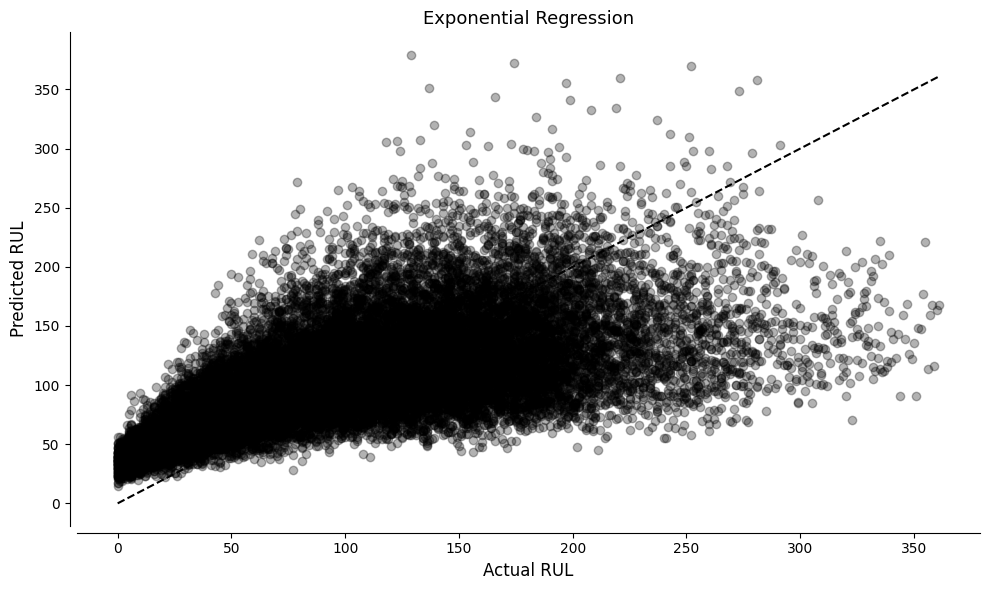

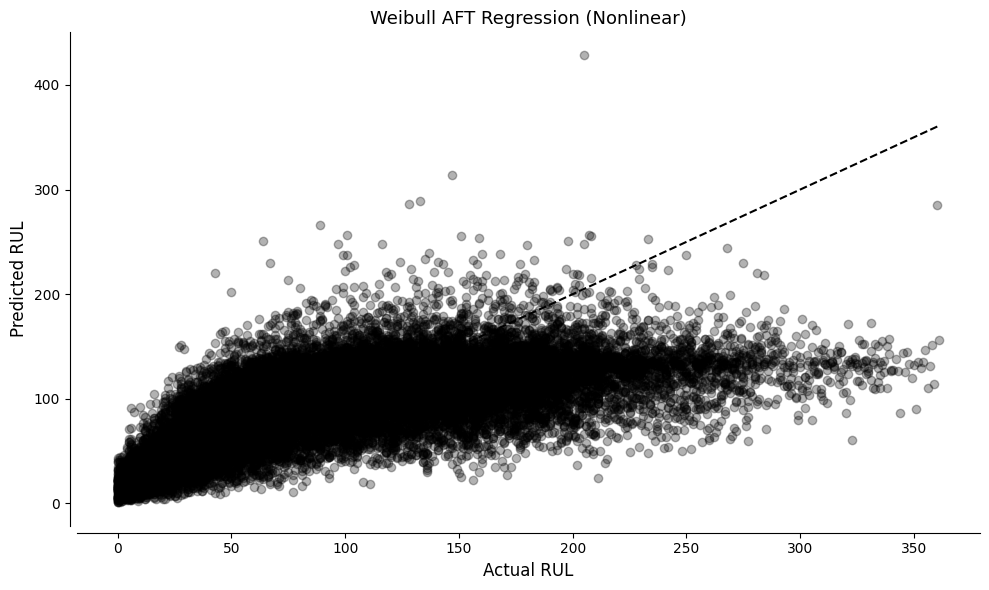

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List
from sklearn.metrics import mean_squared_error
from lifelines import WeibullAFTFitter, CoxPHFitter
import statsmodels.api as sm


def compute_rul(df: pd.DataFrame, time_col: str, group_col: str) -> pd.DataFrame:
    """Compute Remaining Useful Life (RUL) for each row in the dataset."""
    df["max_cycle"] = df.groupby(group_col)[time_col].transform("max")
    df["RUL"] = df["max_cycle"] - df[time_col]
    return df


def generate_sensor_columns(df: pd.DataFrame, prefix: str = "sensor_measurement_") -> List[str]:
    """Return a list of sensor columns."""
    return [col for col in df.columns if col.startswith(prefix)]


def fit_exponential_regression(df: pd.DataFrame, y_col: str, x_cols: List[str]):
    """Fit exponential regression using Poisson with log link."""
    X = sm.add_constant(df[x_cols])
    y = df[y_col]
    model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.Log()))
    return model.fit()


def fit_weibull_aft(df: pd.DataFrame, duration_col: str, event_col: str, x_cols: List[str]):
    """Fit Weibull AFT model."""
    aft_df = df[[duration_col, event_col] + x_cols].copy()
    aft_df[duration_col] = aft_df[duration_col].clip(lower=1e-3)
    model = WeibullAFTFitter()
    model.fit(aft_df, duration_col=duration_col, event_col=event_col)
    return model


def fit_cox_ph(df: pd.DataFrame, duration_col: str, event_col: str, x_cols: List[str]):
    """Fit Cox Proportional Hazards model."""
    cox_df = df[[duration_col, event_col] + x_cols].copy()
    cox_df[duration_col] = cox_df[duration_col].clip(lower=1e-3)
    model = CoxPHFitter()
    model.fit(cox_df, duration_col=duration_col, event_col=event_col)
    return model


def plot_predictions(y_true, y_pred, title: str, xlabel: str, ylabel: str, path: Optional[str] = None):
    """Plot actual vs. predicted in minimalist style."""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3, color="black")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], "k--")
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=13)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.tight_layout()
    if path:
        plt.savefig(path)
    plt.show()


def evaluate_rmse(y_true, y_pred) -> float:
    """Compute RMSE between actual and predicted."""
    return mean_squared_error(y_true, y_pred)


# Load CMAPSS dataset
file_path = "train_FD001.txt"
column_names = ["unit_number", "time_in_cycles"] + [f"op_setting_{i}" for i in range(1, 4)] + [f"sensor_measurement_{i}" for i in range(1, 22)]
df = pd.read_csv(file_path, sep="\\s+", header=None, names=column_names)

# Compute RUL
df = compute_rul(df, time_col="time_in_cycles", group_col="unit_number")

# Subset for modeling
df_model = df[["unit_number", "time_in_cycles", "RUL", "sensor_measurement_2", "sensor_measurement_3"]].copy()

# Add non-linear features
df_model["sensor_2_sq"] = df_model["sensor_measurement_2"] ** 2
df_model["sensor_3_sq"] = df_model["sensor_measurement_3"] ** 2
df_model["sensor_2_x_3"] = df_model["sensor_measurement_2"] * df_model["sensor_measurement_3"]

# Prepare input features
features = ["sensor_measurement_2", "sensor_measurement_3", "sensor_2_sq", "sensor_3_sq", "sensor_2_x_3"]

# Fit exponential regression (still linear-only)
exp_model = fit_exponential_regression(df_model, y_col="RUL", x_cols=["sensor_measurement_2", "sensor_measurement_3"])
df_model["rul_pred_exp"] = exp_model.predict()

# Fit Weibull AFT model with nonlinear features
df_model["event_observed"] = 1
weibull_model = fit_weibull_aft(df_model, duration_col="RUL", event_col="event_observed", x_cols=features)
df_model["rul_pred_weibull"] = weibull_model.predict_median(df_model)

# Fit Cox PH model with nonlinear features
cox_model = fit_cox_ph(df_model, duration_col="RUL", event_col="event_observed", x_cols=features)
cox_concordance = cox_model.concordance_index_

# Evaluate and plot
print(f"Exponential RMSE: {evaluate_rmse(df_model['RUL'], df_model['rul_pred_exp']):.2f}")
print(f"Weibull RMSE (nonlinear): {evaluate_rmse(df_model['RUL'], df_model['rul_pred_weibull']):.2f}")
print(f"Cox Concordance (nonlinear): {cox_concordance:.2f}")

plot_predictions(df_model["RUL"], df_model["rul_pred_exp"], "Exponential Regression", "Actual RUL", "Predicted RUL")
plot_predictions(df_model["RUL"], df_model["rul_pred_weibull"], "Weibull AFT Regression (Nonlinear)", "Actual RUL", "Predicted RUL")


In [6]:
df_model.head()

,unit_number,time_in_cycles,RUL,sensor_measurement_2,sensor_measurement_3
0,1,1,191,641.82,1589.70
1,1,2,190,642.15,1591.82
2,1,3,189,642.35,1587.99
3,1,4,188,642.35,1582.79
4,1,5,187,642.37,1582.85


In [7]:
fit_cox_ph(df_model)

TypeError: fit_cox_ph() missing 3 required positional arguments: 'duration_col', 'event_col', and 'x_cols'

In [12]:
# Load the uploaded predictive maintenance dataset for survival modeling
df_new = pd.read_csv("IndFD-PM-DT dataset.csv")

# Prepare the survival dataframe
df_surv = df_new.copy()

# Simulate "Remaining Useful Life" (RUL) by reversing the index
df_surv["RUL"] = df_surv.groupby("Fault_Diagnosis").cumcount(ascending=False) + 1
df_surv["event_observed"] = np.where(df_surv["Fault_Diagnosis"] > 0, 1, 0)

# Select a subset of features for modeling
df_surv["Vibration_sq"] = df_surv["Vibration_Level"] ** 2
df_surv["Temp_sq"] = df_surv["Temperature_Readings"] ** 2
df_surv["Vib_x_Temp"] = df_surv["Vibration_Level"] * df_surv["Temperature_Readings"]

features = ["Vibration_Level", "Temperature_Readings", "Vibration_sq", "Temp_sq", "Vib_x_Temp"]

# Fit models using provided functions
X_exp = df_surv[["Vibration_Level", "Temperature_Readings"]]
y_exp = df_surv["RUL"]
X_exp = sm.add_constant(X_exp)
exp_model = sm.GLM(y_exp, X_exp, family=sm.families.Poisson(link=sm.families.links.Log())).fit()
df_surv["rul_pred_exp"] = exp_model.predict(X_exp)

aft_model = WeibullAFTFitter()
aft_model.fit(df_surv[["RUL", "event_observed"] + features], duration_col="RUL", event_col="event_observed")
df_surv["rul_pred_weibull"] = aft_model.predict_median(df_surv)

cox_model = CoxPHFitter()
cox_model.fit(df_surv[["RUL", "event_observed"] + features], duration_col="RUL", event_col="event_observed")
cox_concordance = cox_model.concordance_index_

# Compute RMSEs
rmse_exp = mean_squared_error(df_surv["RUL"], df_surv["rul_pred_exp"])
rmse_weibull = mean_squared_error(df_surv["RUL"], df_surv["rul_pred_weibull"])

rmse_exp, rmse_weibull, cox_concordance


(92604845.64593944, 1713111546.4939172, np.float64(0.5052818964968339))

Exponential RMSE: 92540294.04
Weibull RMSE: 1765415730.53
Cox Concordance Index: 0.513


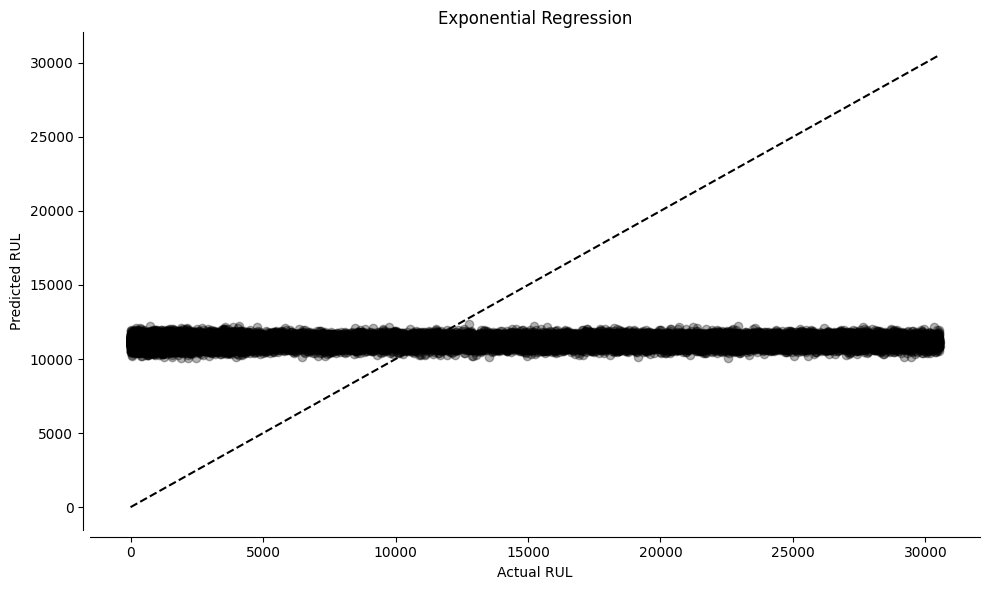

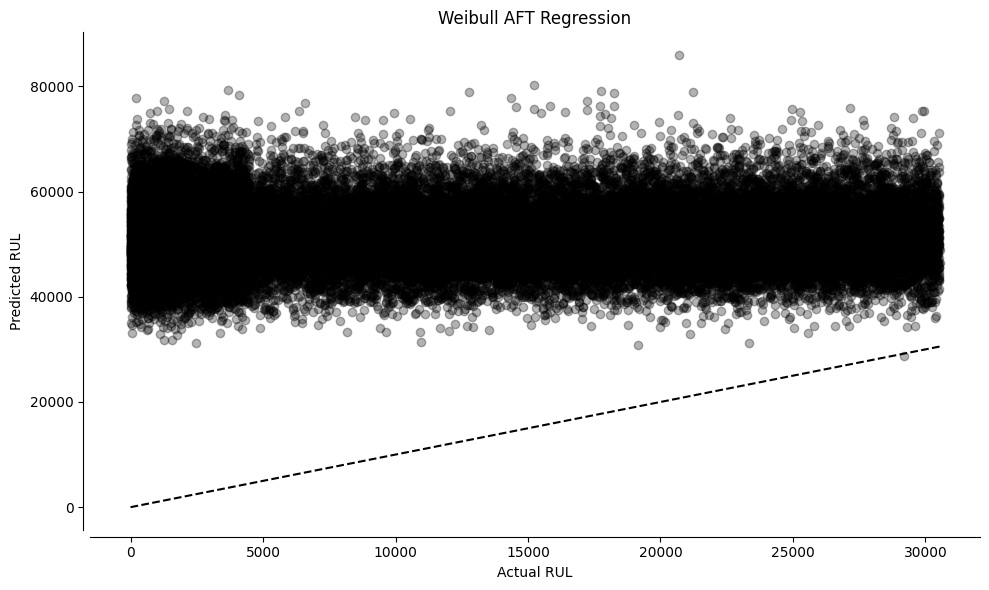

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from lifelines import WeibullAFTFitter, CoxPHFitter
import matplotlib.pyplot as plt


def prepare_data(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath)

    # Simulate RUL as reverse index per Fault_Diagnosis group
    df["RUL"] = df.groupby("Fault_Diagnosis").cumcount(ascending=False) + 1
    df["event_observed"] = np.where(df["Fault_Diagnosis"] > 0, 1, 0)

    # Drop datetime and categorical if present
    if "Datetime" in df.columns:
        df = df.drop(columns=["Datetime"])
    if "Operator_Shift_Data" in df.columns:
        df = pd.get_dummies(df, columns=["Operator_Shift_Data"], drop_first=True)

    return df


def scale_features(df: pd.DataFrame, exclude_cols: list) -> pd.DataFrame:
    numeric_cols = df.select_dtypes(include='number').columns.difference(exclude_cols)
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df


def fit_exponential(df: pd.DataFrame, features: list, target: str = "RUL") -> pd.Series:
    X = sm.add_constant(df[features])
    y = df[target]
    model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.Log())).fit()
    return model.predict(X), model


def fit_weibull(df: pd.DataFrame, features: list) -> pd.Series:
    model = WeibullAFTFitter()
    model.fit(df[["RUL", "event_observed"] + features], duration_col="RUL", event_col="event_observed")
    return model.predict_median(df), model


def fit_cox(df: pd.DataFrame, features: list) -> float:
    model = CoxPHFitter()
    model.fit(df[["RUL", "event_observed"] + features], duration_col="RUL", event_col="event_observed")
    return model.concordance_index_, model


def plot_predictions(y_true, y_pred, title, xlabel, ylabel, filename=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3, color="black")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], "k--")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()


if __name__ == "__main__":
    # Load and preprocess
    df = prepare_data("IndFD-PM-DT dataset.csv")
    df = scale_features(df, exclude_cols=["RUL", "event_observed", "Fault_Diagnosis"])
    df = df.astype({col: "float64" for col in all_features})

    # Feature list
    all_features = df.columns.difference(["RUL", "event_observed", "Fault_Diagnosis"]).tolist()

    # Exponential Regression
    df["pred_rul_exp"], exp_model = fit_exponential(df, all_features)
    rmse_exp = mean_squared_error(df["RUL"], df["pred_rul_exp"])
    print(f"Exponential RMSE: {rmse_exp:.2f}")

    # Weibull AFT
    df["pred_rul_weibull"], weibull_model = fit_weibull(df, all_features)
    rmse_weibull = mean_squared_error(df["RUL"], df["pred_rul_weibull"])
    print(f"Weibull RMSE: {rmse_weibull:.2f}")

    # Cox PH
    cox_concordance, cox_model = fit_cox(df, all_features)
    print(f"Cox Concordance Index: {cox_concordance:.3f}")

    # Plot results
    plot_predictions(df["RUL"], df["pred_rul_exp"], "Exponential Regression", "Actual RUL", "Predicted RUL")
    plot_predictions(df["RUL"], df["pred_rul_weibull"], "Weibull AFT Regression", "Actual RUL", "Predicted RUL")


Exponential RMSE (log RUL): 2.00
Weibull RMSE (log RUL): 11024.27


/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Fault_Trigger_Timestamps have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event_observed'].astype(bool)
>>> print(df.loc[events, 'Fault_Trigger_Timestamps'].var())
>>> print(df.loc[~events, 'Fault_Trigger_Timestamps'].var())

A very low variance means that the column Fault_Trigger_Timestamps completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.218. This may imply non-unique solutions to the 

Cox Concordance Index (log RUL): 0.977


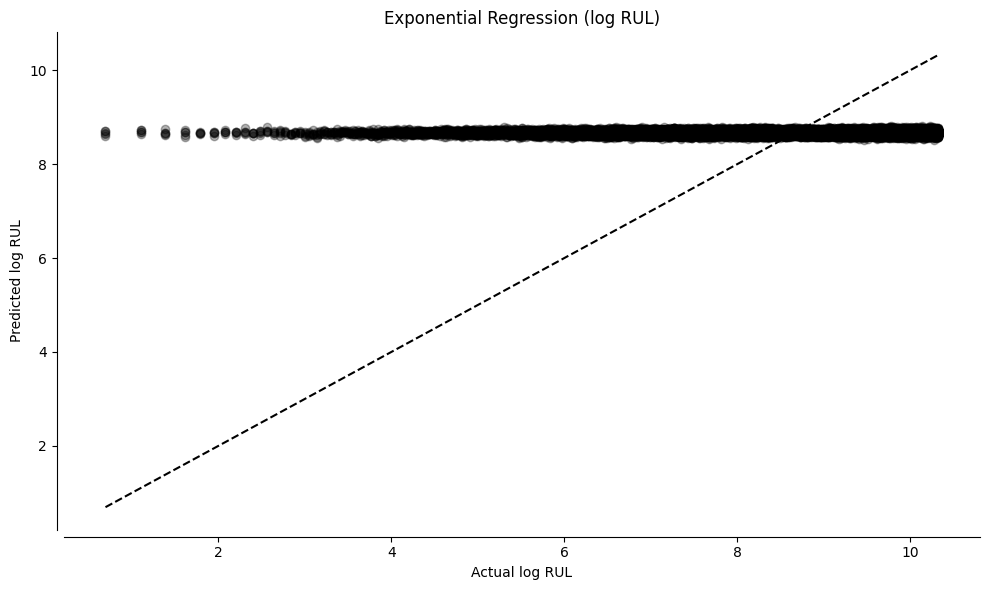

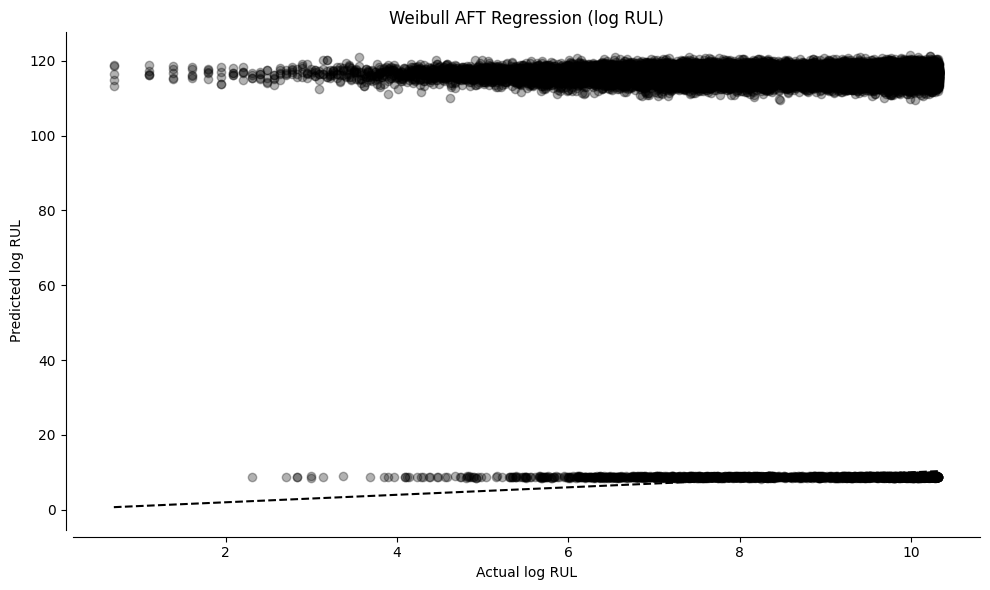

In [19]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from lifelines import WeibullAFTFitter, CoxPHFitter
import matplotlib.pyplot as plt


def prepare_data(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath)

    # Use fault timestamps as event indicators
    if "Fault_Trigger_Timestamps" in df.columns:
        df["event_observed"] = df["Fault_Trigger_Timestamps"]
    elif "Failure_Mode_Indicators" in df.columns:
        df["event_observed"] = df["Failure_Mode_Indicators"]
    else:
        df["event_observed"] = np.where(df["Fault_Diagnosis"] > 0, 1, 0)

    # Simulate RUL using reverse group index within each machine (if available), else fallback by fault class
    if "Machine_ID" in df.columns:
        df["RUL"] = df.groupby("Machine_ID").cumcount(ascending=False) + 1
    else:
        df["RUL"] = df.groupby("Fault_Diagnosis").cumcount(ascending=False) + 1

    # Apply log1p transform to stabilize variance
    df["log_RUL"] = np.log1p(df["RUL"])

    # Drop unused non-numeric or ID columns
    drop_cols = ["Datetime", "Machine_ID"] if "Machine_ID" in df.columns else ["Datetime"]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors="ignore")

    # One-hot encode categorical if present
    if "Operator_Shift_Data" in df.columns:
        df = pd.get_dummies(df, columns=["Operator_Shift_Data"], drop_first=True)

    return df


def scale_features(df: pd.DataFrame, exclude_cols: list) -> pd.DataFrame:
    numeric_cols = df.select_dtypes(include='number').columns.difference(exclude_cols)
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df


def fit_exponential(df: pd.DataFrame, features: list, target: str = "log_RUL"):
    X = sm.add_constant(df[features].apply(pd.to_numeric, errors="coerce"))
    y = pd.to_numeric(df[target], errors="coerce")
    model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.Log())).fit()
    return model.predict(X), model


def fit_weibull(df: pd.DataFrame, features: list):
    model = WeibullAFTFitter()
    model.fit(df[["log_RUL", "event_observed"] + features], duration_col="log_RUL", event_col="event_observed")
    return model.predict_median(df), model


def fit_cox(df: pd.DataFrame, features: list):
    model = CoxPHFitter()
    model.fit(df[["log_RUL", "event_observed"] + features], duration_col="log_RUL", event_col="event_observed")
    return model.concordance_index_, model


def plot_predictions(y_true, y_pred, title, xlabel, ylabel, filename=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3, color="black")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], "k--")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()


if __name__ == "__main__":
    # Load and preprocess
    df = prepare_data("IndFD-PM-DT dataset.csv")
    df = scale_features(df, exclude_cols=["RUL", "log_RUL", "event_observed", "Fault_Diagnosis"])
    df = df.astype({col: "float64" for col in all_features})

    all_features = df.columns.difference(["RUL", "log_RUL", "event_observed", "Fault_Diagnosis"]).tolist()

    # Exponential Regression on log_RUL
    df["pred_log_rul_exp"], exp_model = fit_exponential(df, all_features)
    rmse_exp = mean_squared_error(df["log_RUL"], df["pred_log_rul_exp"])
    print(f"Exponential RMSE (log RUL): {rmse_exp:.2f}")

    # Weibull AFT on log_RUL
    df["pred_log_rul_weibull"], weibull_model = fit_weibull(df, all_features)
    rmse_weibull = mean_squared_error(df["log_RUL"], df["pred_log_rul_weibull"])
    print(f"Weibull RMSE (log RUL): {rmse_weibull:.2f}")

    # CoxPH on log_RUL
    cox_concordance, cox_model = fit_cox(df, all_features)
    print(f"Cox Concordance Index (log RUL): {cox_concordance:.3f}")

    # Plot predictions
    plot_predictions(df["log_RUL"], df["pred_log_rul_exp"], "Exponential Regression (log RUL)", "Actual log RUL", "Predicted log RUL")
    plot_predictions(df["log_RUL"], df["pred_log_rul_weibull"], "Weibull AFT Regression (log RUL)", "Actual log RUL", "Predicted log RUL")
